<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/Ayelen/TP2dmcyt_grafos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install networkx powerlaw community

In [2]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors  
# Para visuzalización en notebook
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

import networkx as nx
# en R está igraph
import community
import powerlaw

from sklearn.metrics import adjusted_rand_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Levanto los datos

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
df_firstrows = pd.read_csv('/content/drive/MyDrive/SWOW-EN.R100.csv', nrows=10000)
df_firstrows.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


Me quedo solo con la columna de claves y primera respuesta

In [68]:
df_firstrows = df_firstrows[['cue','R1']]
df_firstrows.head()

,cue,R1
0,although,nevertheless
1,deal,no
2,music,notes
3,inform,tell
4,way,path


Le pido que me muestre los primeros N datos

In [69]:
N=20
df_firstrows.head(N)

,cue,R1
0,although,nevertheless
1,deal,no
2,music,notes
3,inform,tell
4,way,path
5,none,zilch
6,extra,plus
7,will,free
8,paper,book
9,w,v


Inspección de los datos

In [70]:
print(df_firstrows.shape[0])

10000


In [71]:
# ¿Cuántas claves y respuestas son únicas?
print(df_firstrows['cue'].unique().shape)
print(df_firstrows['R1'].unique().shape)

(1000,)
(3397,)


In [72]:
# ¿cuántas palabras de R1 están en Cue? ¿alrevés?
print(sum(df_firstrows['R1'].isin(df_firstrows['cue'].unique())))
print(sum(df_firstrows['cue'].isin(df_firstrows['R1'].unique())))


5488
8230


Limpio un poco los datos

In [73]:
# Sacar palabras de una letra
df_firstrows.drop(df_firstrows[df_firstrows['cue'].str.len().lt(2)].index, inplace=True)
print(df_firstrows.shape[0])
df_firstrows.drop(df_firstrows[df_firstrows['R1'].str.len().lt(2)].index, inplace=True)
print(df_firstrows.shape[0])

# Sacar nan
df_firstrows.dropna()
print(df_firstrows.shape[0])

9783
9764
9764


In [74]:
print(sum(df_firstrows['R1'].isin(df_firstrows['cue'].unique())==False))
print(sum(df_firstrows['cue'].isin(df_firstrows['R1'].unique())==False))

# Sacar palabras que no este en cue Y en R1
df_firstrows.drop(df_firstrows[df_firstrows['R1'].isin(df_firstrows['cue'].unique())==False].index, inplace=True)
df_firstrows.drop(df_firstrows[df_firstrows['cue'].isin(df_firstrows['R1'].unique())==False].index, inplace=True)

4396
1729


In [75]:
print(df_firstrows.shape[0])

4528


In [76]:
df_firstrows.head()

,cue,R1
1,deal,no
3,inform,tell
6,extra,plus
7,will,free
8,paper,book


Filtro las palabras que no esten en word2vec  FALTA

In [78]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz #obtengo los datos

--2021-11-21 17:58:15--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.230.213
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.230.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  54.8MB/s    in 37s     

2021-11-21 17:58:52 (42.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [101]:
w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

Construyo el grafo


In [81]:
df_firstrows = pd.crosstab(df_firstrows.cue, df_firstrows.R1)
idx = df_firstrows.columns.union(df_firstrows.index)
matriz = df_firstrows.reindex(index = idx, columns=idx, fill_value=0) #armo la matriz de adyacencia

In [82]:
matriz.shape


(804, 804)

In [83]:
matriz.head() # vemos la matriz de adyacencia

,America,Christ,Christmas,English,Europe,France,Friday,Germany,God,Jesus,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,able,about,absolute,accept,act,active,actual,add,affect,after,afternoon,again,against,age,agree,air,all,allow,along,already,alright,also,although,always,...,week,weigh,well,west,what,when,where,whether,which,while,white,who,whole,why,wide,wife,will,win,wind,window,wish,with,without,woman,wonder,wood,word,work,world,worry,worth,would,write,wrong,year,yes,yesterday,yet,you,young
America,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Christ,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Christmas,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
English,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Europe,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
#construyo el grafo

grafo= nx.from_pandas_adjacency(matriz) 

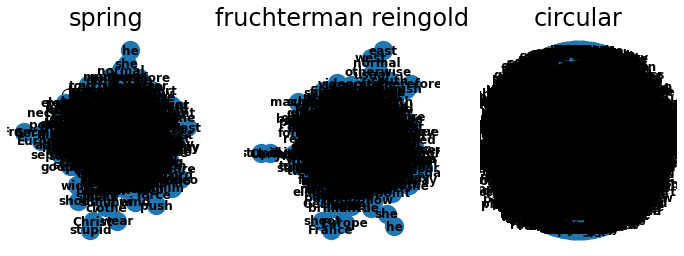

In [89]:
plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(grafo, with_labels=True, font_weight='bold')
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(grafo)
nx.draw(grafo,layout, with_labels=True, font_weight='bold')
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(grafo)
nx.draw(grafo,layout, with_labels=True, font_weight='bold')
plt.title('circular');

Caracterización del grafo

In [94]:
## Número de nodos y de aristas

print(nx.info(grafo))
print('Is weigthed:',nx.is_weighted(grafo))

grafo.number_of_nodes(), grafo.number_of_edges()

Graph with 804 nodes and 2670 edges
Is weigthed: True


(804, 2670)

In [95]:
# Para ver una lista de aristas o nodos
pd.DataFrame.from_dict(grafo.edges).rename(columns={0:'from',1:'to'}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640,2641,2642,2643,2644,2645,2646,2647,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661,2662,2663,2664,2665,2666,2667,2668,2669
from,America,America,America,America,Christ,Christmas,Christmas,Christmas,Christmas,English,English,English,English,Europe,Europe,Europe,France,Friday,Friday,Friday,Friday,Friday,Friday,Germany,God,God,God,God,God,God,God,Jesus,Jesus,Monday,Monday,Monday,Monday,Monday,Monday,Monday,...,transport,travel,tree,trouble,trouble,true,try,try,type,unless,unless,until,up,up,value,view,view,vote,want,war,water,water,we,what,what,what,what,what,what,when,when,whether,why,wife,will,will,with,without,woman,would
to,college,country,free,state,Jesus,holiday,tree,whole,wish,language,subject,tea,word,France,Germany,travel,Germany,Monday,Saturday,Thursday,day,happy,pay,family,Jesus,believe,big,church,create,good,one,church,stupid,Sunday,Thursday,Tuesday,Wednesday,first,morning,today,...,wrong,world,wood,war,yesterday,trust,use,work,write,until,you,when,use,weigh,worth,watch,world,vote,wish,world,well,wind,you,when,where,which,who,why,world,where,why,why,wonder,woman,would,you,without,you,wonder,you


In [96]:
# Tiene multiples aristas o loops
grafo.is_multigraph()

False

In [97]:
# Están conectados?
nx.is_connected(grafo)

True

In [98]:
# diámetro de la red

nx.diameter(grafo)

8

In [99]:
# densidad

nx.density(grafo)

0.008271221724503262

In [100]:
#coeficiente de clustering

nx.average_clustering(grafo)

0.08850726922631985